In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
import yfinance as yf
import warnings
from polygon import RESTClient
warnings.filterwarnings('ignore')
client = RESTClient(api_key='fD3dnEI2SSS6o9Pu32hiBAMIRiTsttt2')


In [21]:
#load datasets
am_df = pd.read_csv("data/american_stock.csv")
eu_df = pd.read_csv("data/european_index.csv")
rf_df = pd.read_csv("data/FEDFUNDS.csv")
european_index_df = pd.read_csv("data/ndx_historical.csv")


In [22]:
rf_df["DATE"] = pd.to_datetime(rf_df["DATE"], format="%Y-%m-%d")

In [23]:
volatility_intervals = 100
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["rf_join_date"] = pd.to_datetime(eu_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
european_index_df["Date"] = pd.to_datetime(european_index_df["Date"])
european_index_df["volatility"] = european_index_df["Close/Last"].rolling(volatility_intervals).std() / european_index_df["Close/Last"]
eu_df = pd.merge(eu_df, rf_df, left_on="rf_join_date", right_on="DATE")
eu_df = pd.merge(eu_df, european_index_df, left_on="date", right_on="Date")
eu_df = eu_df[["date", "exdate", "symbol", "cp_flag", "strike_price", "best_bid", "best_offer", "tte", "Close/Last", "FEDFUNDS", "volatility"]]
eu_df["modeled_price"] = 0 #temporary placeholder
eu_df.head()

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.9,1134.0,7 days,4230.24,0.11,0.027469,0
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.9,1109.0,7 days,4230.24,0.11,0.027469,0
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.9,1084.0,7 days,4230.24,0.11,0.027469,0
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.9,1059.0,7 days,4230.24,0.11,0.027469,0
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.9,1034.0,7 days,4230.24,0.11,0.027469,0


In [101]:
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
am_df["tte"] = am_df["exdate"] - am_df["date"]
am_df["rf_join_date"] = pd.to_datetime(am_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
am_df = pd.merge(am_df, rf_df, left_on="rf_join_date", right_on="DATE")
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style", "tte", "Close/Last", "FEDFUNDS"]]


<ipython-input-101-a0168d33d784>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
<ipython-input-101-a0168d33d784>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
<ipython-input-101-a0168d33d784>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

KeyError: "['Close/Last'] not in index"

In [14]:
#Current assumptions: risk-neutral, a set volatility and that FED rate is essentially the risk-free rate

def simple_european_binomial_model(n_steps, vol, underlying_price, strike, tte, int_rate, call=True):
    """
    Returns the modeled price of a European options contract. 
    n_steps: number of steps
    vol: volatility (in float)
    underlying_price: initial stock price
    strike: strike price of option
    tte: time to expiration of contract (in days)
    int_rate: risk-free interest rate
    call: boolean True if call, False otherwise
    """
    dt = (tte/365)/n_steps
    u = math.exp(vol*math.sqrt(dt))
    d = 1/u
    p = (math.exp(int_rate*dt)-d)/(u-d)
    
    stock_prices = [] #possible stock prices at the latest time
    options_prices = [] #options values at the respective times
    for i in range(0,n_steps+1):
        stock_prices.append(underlying_price*(u**(n_steps-i))*(d**i))
        if call:
            options_prices.append(max(0,stock_prices[i]-strike))
        else:
            options_prices.append(max(0,strike-stock_prices[i]))
    #combine options data backwards in pairs
    counter = n_steps-1
    while counter > -1:
        for i in range(counter+1):
            price = math.exp(-int_rate*dt)*(p*options_prices[i] + (1-p)*options_prices[i+1])
            options_prices[i] = price
        counter-=1
    return options_prices[0]

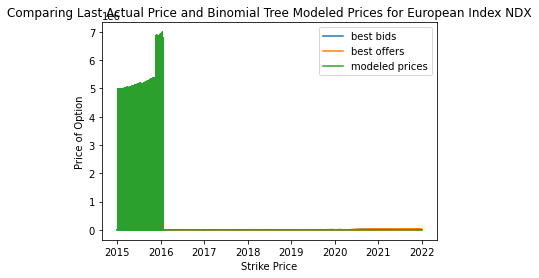

In [38]:
#To test other models, just change the parameters needed, docs will be added later
for i in range(0,10000): 
  vol = eu_df["volatility"][i]
  stock_price = eu_df["Close/Last"][i]
  strike = eu_df["strike_price"][i]/1000
  tte = eu_df["tte"][i].days
  int_rate = eu_df["FEDFUNDS"][i]
  call = True if eu_df["cp_flag"][i] == 'C' else False
  eu_df["modeled_price"][i] = simple_european_binomial_model(30,vol,stock_price,strike,tte,int_rate,call)


plt.plot(eu_df['date'].to_numpy(),eu_df['best_bid'].to_numpy(),label="best bids")
plt.plot(eu_df['date'].to_numpy(),eu_df['best_offer'].to_numpy(),label="best offers")
plt.plot(eu_df['date'].to_numpy(),eu_df["modeled_price"].to_numpy(),label="modeled prices")
plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for European Index NDX')
plt.ylabel('Price of Option')
plt.xlabel('Strike Price')
plt.legend()
plt.show()

In [37]:
eu_df.head()

,date,exdate,symbol,cp_flag,strike_price,best_bid,best_offer,tte,Close/Last,FEDFUNDS,volatility,modeled_price
0,2015-01-02,2015-01-09,NDX 150109C3100000,C,3100000,1124.9,1134.0,7 days,4230.24,0.11,0.027469,1136.772833
1,2015-01-02,2015-01-09,NDX 150109C3125000,C,3125000,1099.9,1109.0,7 days,4230.24,0.11,0.027469,1111.825517
2,2015-01-02,2015-01-09,NDX 150109C3150000,C,3150000,1074.9,1084.0,7 days,4230.24,0.11,0.027469,1086.878201
3,2015-01-02,2015-01-09,NDX 150109C3175000,C,3175000,1049.9,1059.0,7 days,4230.24,0.11,0.027469,1061.930885
4,2015-01-02,2015-01-09,NDX 150109C3200000,C,3200000,1024.9,1034.0,7 days,4230.24,0.11,0.027469,1036.983569


In [65]:
#Current assumptions: #Current assumptions: risk-neutral, a set volatility and that FED rate is essentially the risk-free rate
def american_binomial_model(n_steps, vol, underlying_price, strike, tte, int_rate, call=True):
    """
    Returns the modeled price of an American options contract. 
    n_steps: number of steps
    vol: volatility (in float)
    underlying_price: initial stock price
    strike: strike price of option
    tte: time to expiration of contract (in days)
    int_rate: risk-free interest rate
    call: boolean True if call, False otherwise
    """
    dt = (tte/365)/n_steps
    u = math.exp(vol*math.sqrt(dt))
    d = 1/u
    p = (math.exp(int_rate*dt)-d)/(u-d)
    #initialize arrays to hold stock/options_payoff values 
    stock_prices = [0]*(n_steps+1)
    for i in range(1,n_steps+1):
        stock_prices[i]= [0]*(i+1)
    options_payoff = stock_prices.copy()
    stock_prices[0] = underlying_price
    #calculate possible stock prices 
    for i in range(1,n_steps+1):
        for j in range(i+1):
            stock_prices[i][j] = underlying_price*(u**(i-j))*(d**j)
            
    #calculate options payoffs at the respective times depending on stock prices
    for i in range(1,n_steps+1):
        for j in range(i+1):
            if call:
                options_payoff[i][j] = max(0,stock_prices[i][j]-strike)
            else:
                options_payoff[i][j] = max(0,strike-stock_prices[i][j])
    
    #calculate max(options payoff if exercised early, option value)
    option_value = options_payoff[:]
    for i in range(n_steps-1,0,-1):
        for j in range(i+1):
            option_value[i][j] = max(options_payoff[i][j], (math.exp(-int_rate * dt)*(p * option_value[i+1][j] + (1-p)*option_value[i+1][j+1])))  
    return math.exp(-int_rate*dt)*(p*option_value[1][0] + (1-p)*option_value[1][1])
        # Calculate option values at earlier times

      contractSymbol             lastTradeDate  strike  lastPrice   bid   ask   
0  DD230519C00035000 2023-04-06 15:47:27+00:00    35.0      34.50  30.2  31.3  \
1  DD230519C00045000 2023-04-28 18:42:18+00:00    45.0      24.80  19.8  21.5   
2  DD230519C00047500 2023-03-31 19:03:02+00:00    47.5      24.40  21.9  22.7   
3  DD230519C00055000 2023-04-10 16:43:14+00:00    55.0      14.65  10.3  10.9   
4  DD230519C00062000 2023-05-04 14:32:51+00:00    62.0       2.55   3.8   4.1   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney   
0     0.0            0.0     3.0             3           1.851563        True  \
1     0.0            0.0     1.0             1           1.078130        True   
2     0.0            0.0     7.0             8           2.643558        True   
3     0.0            0.0     8.0            11           0.521489        True   
4     0.0            0.0    12.0            36           0.382330        True   

  contractSize currency  m

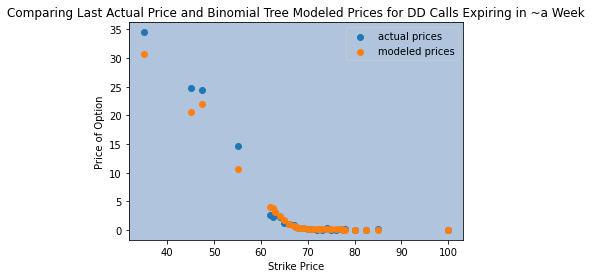

       contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  XOM230519C00050000 2023-05-02 19:10:19+00:00    50.0      60.70  58.45  \
1  XOM230519C00055000 2023-05-02 19:05:56+00:00    55.0      55.85  53.45   
2  XOM230519C00060000 2023-05-04 14:46:41+00:00    60.0      46.80  48.50   
3  XOM230519C00065000 2023-04-24 14:27:17+00:00    65.0      52.75  43.50   
4  XOM230519C00070000 2023-05-05 18:57:45+00:00    70.0      39.50  38.50   

     ask    change  percentChange  volume  openInterest  impliedVolatility   
0  58.95  0.000000       0.000000     3.0           5.0           1.500002  \
1  53.95  0.000000       0.000000     3.0           3.0           1.328128   
2  48.95  0.000000       0.000000     1.0           6.0           1.281254   
3  43.95  0.000000       0.000000     5.0          20.0           1.125004   
4  38.95 -0.650002      -1.618933     3.0          15.0           0.976563   

   inTheMoney contractSize currency  modeled_price  percent_error  


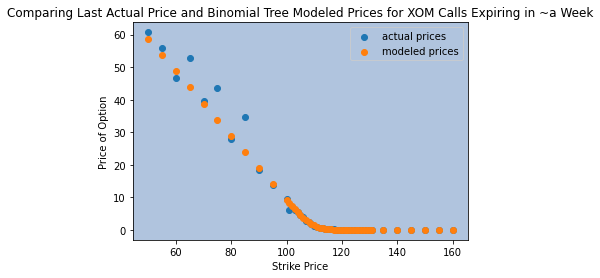

       contractSymbol             lastTradeDate  strike  lastPrice   bid   
0  SHW230519C00200000 2023-04-26 18:52:56+00:00   200.0      31.13  28.5  \
1  SHW230519C00210000 2023-05-03 16:51:11+00:00   210.0      25.11  20.5   
2  SHW230519C00220000 2023-05-03 15:21:21+00:00   220.0      14.50   9.5   
3  SHW230519C00230000 2023-05-05 16:11:58+00:00   230.0       3.92   4.5   
4  SHW230519C00240000 2023-05-05 18:46:06+00:00   240.0       1.10   0.9   

    ask  change  percentChange  volume  openInterest  impliedVolatility   
0  35.0    0.00       0.000000     4.0            60           0.559331  \
1  24.3    0.00       0.000000    10.0            49           0.654056   
2  12.9    0.00       0.000000     1.0           132           0.352546   
3   5.0   -0.08      -1.999998     2.0           248           0.263313   
4   1.3    0.00       0.000000    31.0           609           0.251716   

   inTheMoney contractSize currency  modeled_price  percent_error  
0        True      REGUL

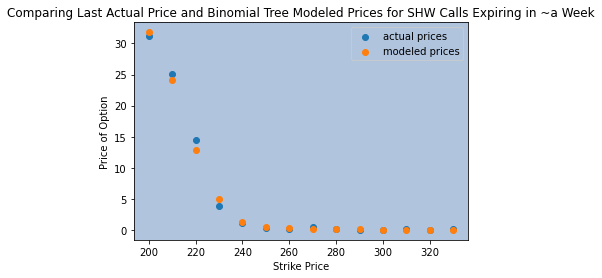

       contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  CVX230519C00080000 2023-04-25 14:26:25+00:00    80.0      88.85  80.00  \
1  CVX230519C00090000 2023-04-27 14:09:54+00:00    90.0      76.35  70.00   
2  CVX230519C00095000 2023-04-26 17:18:50+00:00    95.0      72.95  65.00   
3  CVX230519C00105000 2023-05-04 19:36:23+00:00   105.0      55.00  55.05   
4  CVX230519C00110000 2023-05-03 17:50:12+00:00   110.0      49.15  50.05   

     ask    change  percentChange  volume  openInterest  impliedVolatility   
0  80.65  0.000000       0.000000     1.0             1           1.583986  \
1  70.65  0.000000       0.000000     1.0             5           1.335941   
2  65.60  0.000000       0.000000     1.0             2           1.183598   
3  55.65  2.849998       5.465002     1.0            21           1.037114   
4  50.70  0.000000       0.000000     3.0            19           0.958985   

   inTheMoney contractSize currency  modeled_price  percent_error  


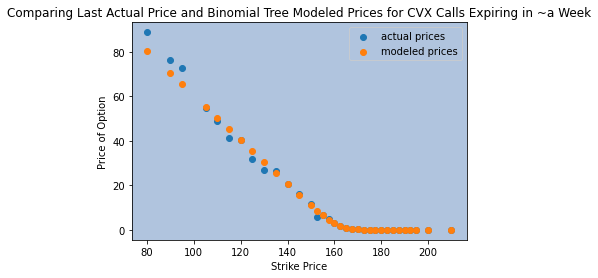

      contractSymbol             lastTradeDate  strike  lastPrice     bid   
0  BA230519C00065000 2023-05-01 13:38:15+00:00    65.0     142.00  132.85  \
1  BA230519C00070000 2023-05-04 16:31:26+00:00    70.0     124.95  128.00   
2  BA230519C00075000 2023-02-06 18:35:16+00:00    75.0     133.75  132.40   
3  BA230519C00080000 2022-12-22 17:42:13+00:00    80.0     108.50  127.45   
4  BA230519C00085000 2022-11-03 17:34:25+00:00    85.0      73.93   99.60   

      ask  change  percentChange  volume  openInterest  impliedVolatility   
0  133.75     0.0            0.0     1.0            12           2.847659  \
1  128.85     0.0            0.0     1.0             4           2.175786   
2  133.65     0.0            0.0     1.0            32           5.256107   
3  129.25     0.0            0.0     3.0            13           5.016117   
4  101.00     0.0            0.0     5.0            18           0.000010   

   inTheMoney contractSize currency  modeled_price  percent_error  
0     

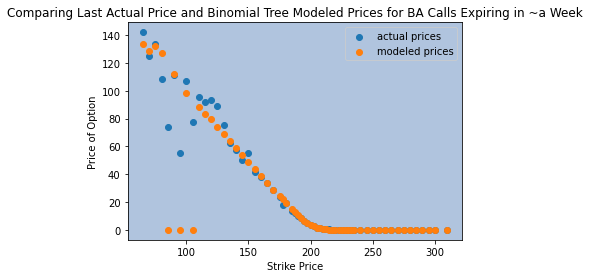

       contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  UNP230519C00095000 2023-02-28 14:58:00+00:00    95.0     114.31  103.4  \
1  UNP230519C00135000 2023-04-04 14:30:00+00:00   135.0      63.05   61.6   
2  UNP230519C00140000 2023-04-17 14:05:11+00:00   140.0      61.10   60.9   
3  UNP230519C00150000 2023-01-24 17:05:20+00:00   150.0      55.13   44.1   
4  UNP230519C00155000 2023-03-09 16:05:57+00:00   155.0      50.10   44.1   

     ask  change  percentChange  volume  openInterest  impliedVolatility   
0  104.6     0.0            0.0     NaN             1           0.000010  \
1   63.0     0.0            0.0     1.0             1           0.000010   
2   62.6     0.0            0.0     NaN             1           1.083012   
3   45.2     0.0            0.0     NaN             1           0.000010   
4   45.3     0.0            0.0     1.0             1           0.000010   

   inTheMoney contractSize currency  modeled_price  percent_error  
0        Tru

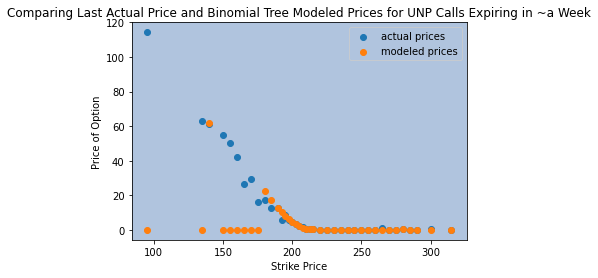

       contractSymbol             lastTradeDate  strike  lastPrice   bid   
0  DUK230519C00070000 2023-05-03 19:37:01+00:00    70.0       27.9  28.6  \
1  DUK230519C00075000 2023-05-04 13:50:18+00:00    75.0       22.5  23.8   
2  DUK230519C00080000 2023-05-04 15:09:08+00:00    80.0       18.1  19.0   
3  DUK230519C00085000 2023-05-04 19:09:23+00:00    85.0       13.3  14.0   
4  DUK230519C00090000 2023-05-03 17:18:46+00:00    90.0        8.7   9.0   

    ask  change  percentChange  volume  openInterest  impliedVolatility   
0  30.1     0.0            0.0       2             3           1.316410  \
1  24.9     0.0            0.0       7            16           1.024419   
2  19.9     0.0            0.0       6            36           0.582035   
3  14.9     0.0            0.0       7            75           0.648929   
4   9.9     0.0            0.0       5            99           0.465337   

   inTheMoney contractSize currency  modeled_price  percent_error  
0        True      REGUL

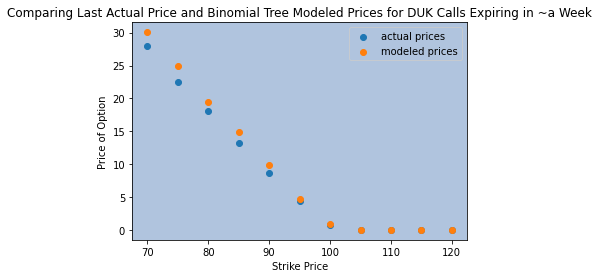

       contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  JNJ230519C00095000 2023-04-18 19:40:16+00:00    95.0      66.75  67.55  \
1  JNJ230519C00100000 2023-03-08 15:15:00+00:00   100.0      54.20  65.20   
2  JNJ230519C00105000 2023-03-09 15:38:29+00:00   105.0      48.00  60.40   
3  JNJ230519C00110000 2023-04-11 19:21:07+00:00   110.0      54.95  52.30   
4  JNJ230519C00115000 2023-03-06 20:04:13+00:00   115.0      41.30  51.00   

     ask  change  percentChange  volume  openInterest  impliedVolatility   
0  68.10     0.0            0.0     NaN             2           1.292972  \
1  66.20     0.0            0.0     1.0            19           2.182622   
2  61.15     0.0            0.0    49.0            64           2.025640   
3  53.10     0.0            0.0     2.0            10           0.765627   
4  51.45     0.0            0.0     3.0            17           1.776612   

   inTheMoney contractSize currency  modeled_price  percent_error  
0        Tru

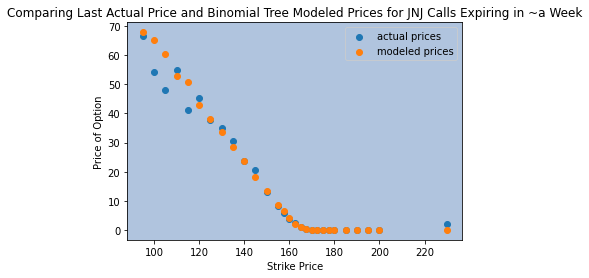

       contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  JPM230519C00070000 2023-05-04 14:17:16+00:00    70.0      63.15  62.95  \
1  JPM230519C00075000 2023-04-04 19:50:05+00:00    75.0      53.15  58.85   
2  JPM230519C00080000 2023-04-21 15:56:49+00:00    80.0      60.45  56.55   
3  JPM230519C00090000 2023-04-13 18:59:47+00:00    90.0      39.15  46.55   
4  JPM230519C00095000 2023-05-05 18:58:51+00:00    95.0      42.21  41.60   

     ask    change  percentChange  volume  openInterest  impliedVolatility   
0  65.50 -3.150002      -4.751133     NaN           NaN           0.000010  \
1  60.30  0.000000       0.000000     2.0           0.0           0.000010   
2  57.25  0.000000       0.000000     1.0           4.0           1.337894   
3  47.20  0.000000       0.000000     1.0           0.0           1.046880   
4  42.25 -2.090000      -4.717834     2.0           1.0           0.972657   

   inTheMoney contractSize currency  modeled_price  percent_error  


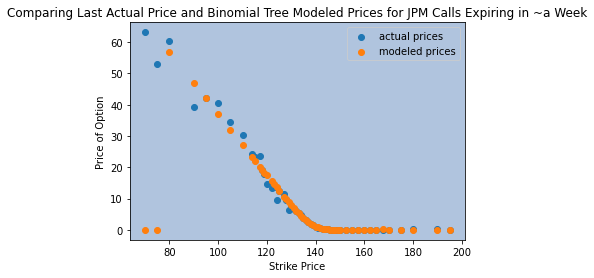

      contractSymbol             lastTradeDate  strike  lastPrice     bid   
0  GS230519C00155000 2023-04-21 19:45:04+00:00   155.0     186.70  171.15  \
1  GS230519C00185000 2023-04-19 14:59:47+00:00   185.0     149.90  141.45   
2  GS230519C00195000 2023-04-18 17:32:54+00:00   195.0     141.10  129.95   
3  GS230519C00205000 2023-04-12 14:25:00+00:00   205.0     124.65  121.55   
4  GS230519C00220000 2023-04-12 18:27:21+00:00   220.0     112.00  106.55   

      ask  change  percentChange  volume  openInterest  impliedVolatility   
0  173.25     0.0            0.0     2.0             2           1.638674  \
1  143.20     0.0            0.0     NaN             4           1.369144   
2  133.40     0.0            0.0     NaN             4           1.608400   
3  123.85     0.0            0.0     NaN             1           1.295902   
4  108.85     0.0            0.0     NaN             1           1.124028   

   inTheMoney contractSize currency  modeled_price  percent_error  
0     

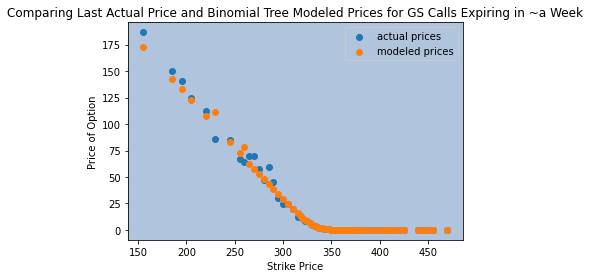

        contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  AMZN230519C00050000 2023-05-05 17:26:20+00:00    50.0      55.39  55.55  \
1  AMZN230519C00055000 2023-04-24 14:38:32+00:00    55.0      51.53  50.55   
2  AMZN230519C00060000 2023-05-05 14:23:32+00:00    60.0      45.03  45.40   
3  AMZN230519C00065000 2023-05-05 18:25:39+00:00    65.0      40.43  40.60   
4  AMZN230519C00070000 2023-05-02 19:00:21+00:00    70.0      34.00  35.60   

     ask    change  percentChange  volume  openInterest  impliedVolatility   
0  55.95  0.889999       1.633026       6            84           1.746095  \
1  50.95  0.000000       0.000000       1            30           1.542971   
2  46.10  1.129997       2.574025       2            70           1.355472   
3  40.95 -2.020001      -4.758541       1            93           1.220707   
4  36.00  0.000000       0.000000       1           171           1.085942   

   inTheMoney contractSize currency  modeled_price  percent_er

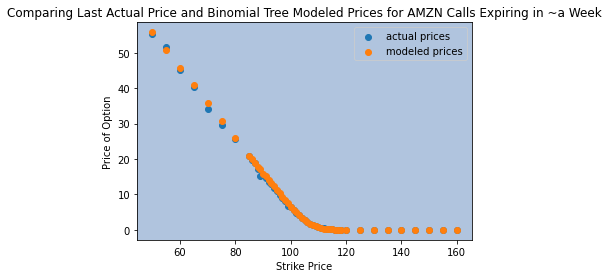

       contractSymbol             lastTradeDate  strike  lastPrice     bid   
0  MCD230519C00160000 2023-04-18 15:21:25+00:00   160.0     130.87  136.00  \
1  MCD230519C00200000 2023-03-13 14:03:57+00:00   200.0      69.30   85.90   
2  MCD230519C00210000 2023-04-03 18:43:06+00:00   210.0      74.15   85.25   
3  MCD230519C00225000 2023-03-16 19:43:05+00:00   225.0      48.00   64.45   
4  MCD230519C00230000 2023-05-04 19:47:07+00:00   230.0      65.20   66.50   

      ask  change  percentChange  volume  openInterest  impliedVolatility   
0  137.45     0.0            0.0     NaN             1           1.332035  \
1   86.55     0.0            0.0     NaN             8           0.000010   
2   86.30     0.0            0.0     2.0             5           0.000010   
3   65.95     0.0            0.0     NaN             1           0.000010   
4   67.25     0.0            0.0     1.0             0           0.670902   

   inTheMoney contractSize currency  modeled_price  percent_error  


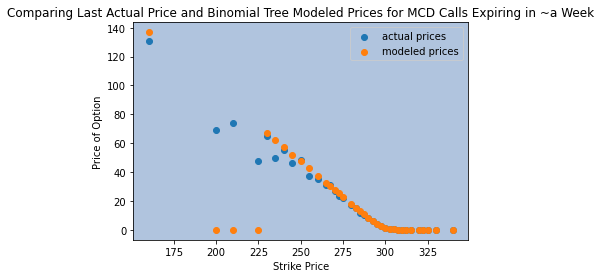

      contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  PG230519C00075000 2023-04-19 15:24:30+00:00    75.0      76.05  80.85  \
1  PG230519C00085000 2023-05-01 19:39:42+00:00    85.0      71.80  70.80   
2  PG230519C00095000 2023-04-19 15:24:30+00:00    95.0      56.05  60.90   
3  PG230519C00100000 2023-04-19 13:33:53+00:00   100.0      51.55  55.85   
4  PG230519C00120000 2023-04-21 17:56:22+00:00   120.0      37.00  35.90   

     ask  change  percentChange  volume  openInterest  impliedVolatility   
0  81.35     0.0            0.0     NaN           0.0           1.570315  \
1  71.35     0.0            0.0     NaN           0.0           1.257816   
2  61.40     0.0            0.0     2.0           0.0           1.177738   
3  56.35     0.0            0.0     4.0           0.0           0.996094   
4  36.40     0.0            0.0     1.0           1.0           0.669925   

   inTheMoney contractSize currency  modeled_price  percent_error  
0        True     

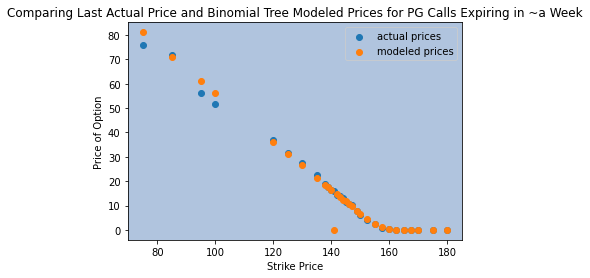

        contractSymbol             lastTradeDate  strike  lastPrice     bid   
0  AAPL230519C00050000 2023-05-04 16:07:56+00:00    50.0     115.40  122.30  \
1  AAPL230519C00055000 2023-03-16 16:46:51+00:00    55.0     100.20  109.30   
2  AAPL230519C00060000 2023-05-05 16:13:46+00:00    60.0     113.92  113.05   
3  AAPL230519C00065000 2023-01-09 14:31:47+00:00    65.0      67.15   88.20   
4  AAPL230519C00070000 2023-05-04 17:53:34+00:00    70.0      96.20  102.80   

      ask  change  percentChange  volume  openInterest  impliedVolatility   
0  124.15    0.00       0.000000    10.0             9           3.408205  \
1  111.05    0.00       0.000000     NaN             5           0.000010   
2  114.10    9.07       8.650453     2.0          2698           1.718751   
3   88.50    0.00       0.000000     2.0          2758           0.000010   
4  104.45    0.00       0.000000     3.0          2043           1.847657   

   inTheMoney contractSize currency  modeled_price  percent_er

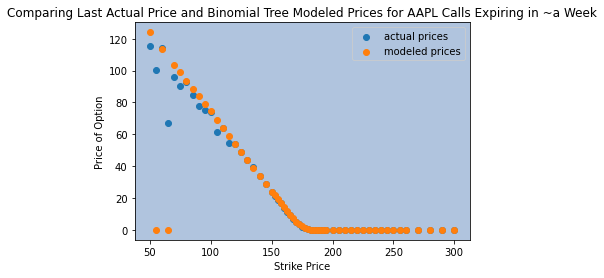

        contractSymbol             lastTradeDate  strike  lastPrice     bid   
0  MSFT230519C00125000 2023-05-05 15:31:01+00:00   125.0     183.20  183.75  \
1  MSFT230519C00130000 2023-04-27 19:39:37+00:00   130.0     175.21  178.80   
2  MSFT230519C00140000 2023-05-01 14:29:38+00:00   140.0     166.54  169.25   
3  MSFT230519C00145000 2023-05-01 14:29:38+00:00   145.0     161.57  163.55   
4  MSFT230519C00150000 2023-03-14 19:57:44+00:00   150.0     112.00  139.10   

      ask  change  percentChange  volume  openInterest  impliedVolatility   
0  187.30   -0.75       -0.40772     1.0            22           2.767093  \
1  182.40    0.00        0.00000     1.0             1           2.689456   
2  171.80    0.00        0.00000     2.0             1           2.296879   
3  167.50    0.00        0.00000     2.0             0           2.412602   
4  141.75    0.00        0.00000     4.0            25           0.000010   

   inTheMoney contractSize currency  modeled_price  percent_er

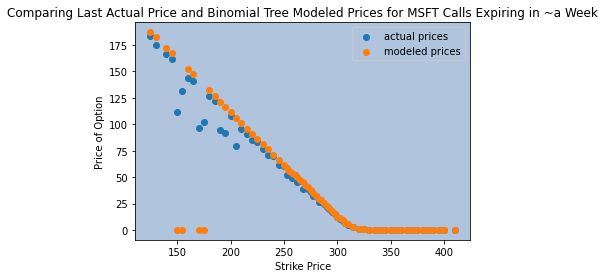

        contractSymbol             lastTradeDate  strike  lastPrice    bid   
0  GOOG230519C00050000 2023-04-26 13:34:31+00:00    50.0      55.80  54.20  \
1  GOOG230519C00055000 2023-04-17 15:00:57+00:00    55.0      51.34  49.20   
2  GOOG230519C00060000 2023-05-05 13:30:01+00:00    60.0      45.75  44.20   
3  GOOG230519C00065000 2023-03-24 16:23:40+00:00    65.0      40.85  39.30   
4  GOOG230519C00070000 2023-05-01 19:40:50+00:00    70.0      37.70  34.25   

     ask  change  percentChange  volume  openInterest  impliedVolatility   
0  57.85    0.00       0.000000       1            12           2.964846  \
1  52.85    0.00       0.000000       1             8           2.645511   
2  47.85   -0.25      -0.543478      70            70           2.353520   
3  43.20    0.00       0.000000      11            18           1.046880   
4  37.90    0.00       0.000000       1            38           1.847657   

   inTheMoney contractSize currency  modeled_price  percent_error  
0     

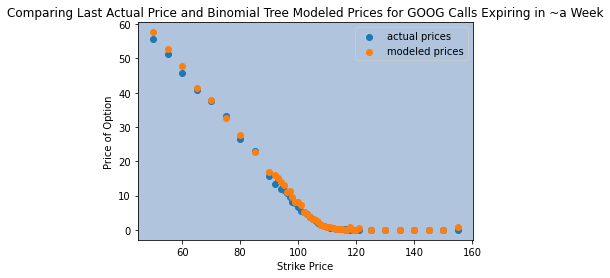

       contractSymbol             lastTradeDate  strike  lastPrice   bid   
0  AMT230519C00140000 2023-04-12 19:52:29+00:00   140.0      71.10  56.0  \
1  AMT230519C00150000 2023-05-02 13:38:52+00:00   150.0      53.39  46.1   
2  AMT230519C00155000 2023-03-02 17:27:22+00:00   155.0      40.89  47.8   
3  AMT230519C00170000 2023-05-04 13:47:31+00:00   170.0      23.80  26.4   
4  AMT230519C00175000 2023-03-22 19:44:25+00:00   175.0      22.46  28.9   

    ask  change  percentChange  volume  openInterest  impliedVolatility   
0  57.8     0.0            0.0     2.0             0           0.839845  \
1  47.8     0.0            0.0    10.0            10           0.719729   
2  50.9     0.0            0.0     NaN             2           1.722413   
3  28.0     0.0            0.0     2.0             3           0.645511   
4  30.7     0.0            0.0     NaN             1           1.198857   

   inTheMoney contractSize currency  modeled_price  percent_error  
0        True      REGUL

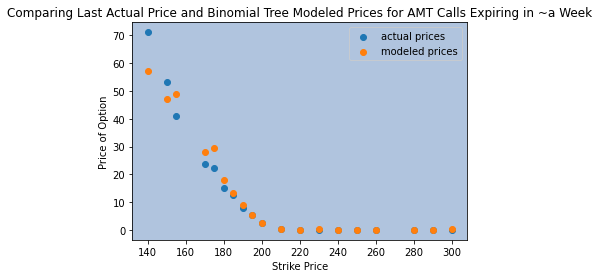

In [72]:
int_rate = 0.0344 #risk free interest rate today
def compare(ticker,date):
    """
    Generates plots comparing the modeled prices from the Binomial Model Tree to 
    actual stock data.
    ticker: ticker for the stock
    date: options expiration date
    """
    formatted_date = datetime.date(int(date[0:4]),int(date[5:7]),int(date[8::]))
    tte = formatted_date - datetime.date.today()
    stock = yf.Ticker(ticker)
    stock_price = stock.info['currentPrice']
    opt_chain = stock.option_chain(date)
    calls = opt_chain.calls
    calls["modeled_price"] = 0
    calls["percent_error"] = 0
    for i in range(0,calls.shape[0]):
        calculated_price = american_binomial_model(100,calls['impliedVolatility'][i],stock_price,calls['strike'][i],tte.days,int_rate,True)
        calls["modeled_price"][i] = calculated_price if (calculated_price < 2000 and calculated_price > 0) else 0
        calls["percent_error"][i] = abs((calls['lastPrice'][i] - calls["modeled_price"][i])/calls['lastPrice'][i])
    print("The model has an accuracy of " + str(calls["percent_error"].mean()) + " over the whole chain.")
    print("The model has an accuracy of " + str(calls["percent_error"].mean()) + " .")
    plt.scatter(calls['strike'].to_numpy(),calls['lastPrice'].to_numpy(),label="actual prices")
    plt.scatter(calls['strike'].to_numpy(),calls["modeled_price"].to_numpy(),label="modeled prices")
    plt.title('Comparing Last Actual Price and Binomial Tree Modeled Prices for ' + ticker + ' Calls Expiring in ~a Week')
    plt.ylabel('Price of Option')
    plt.xlabel('Strike Price')
    plt.legend()
    plt.show()
    return 

stocks = {
    "DD":'2023-05-19', #Energy Sector
    "XOM":'2023-05-19', #Energy Sector
    "SHW":'2023-05-19', #Materials Sector
    "CVX":'2023-05-19', #Materials Sector
    "BA":'2023-05-19', #Industrial Sector
    "UNP":'2023-05-19', #Industrial Sector
    "DUK": '2023-05-19', #Healthcare
    "JNJ": '2023-05-19', #Healthcare
    "JPM": '2023-05-19', #Financial
    "GS" :'2023-05-19', #Financial
    "AMZN" :'2023-05-19', #Consumer Discretionary Sector
    "MCD" :'2023-05-19', #Consumer Discretionary Sector
    "PG" :'2023-05-19',#Consume Staples Sector
    "AAPL":'2023-05-19', #Tech Sector
    "MSFT": '2023-05-19',#Tech Sector
    "GOOG":'2023-05-19', #Communication Sector
    "AMT": '2023-05-19', #Real Estate
    }

for key in stocks:
    compare(key,'2023-05-19')